In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, find_icjc, compute_tilt_data, tilt_distance_LI


In [2]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

In [3]:
sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]


In [4]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [5]:
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


For each eddy-day, I will interpolate the rho at each vertical center. 


In [7]:
dic_rho_sample = {}
for eddy in sample_eddies:
    dic = dic_sample[f'Eddy{eddy}'].copy()
    dic_rho_sample[f'Eddy{eddy}'] = {}
    
    fname_old = None
    ocean_time = None
    rho = None  
    
    for day_key in dic.keys():                 
        day = int(day_key[3:])                    
    
        surf_data = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies.Day == day)].iloc[0]
        df = dic[f'Day{day}'].copy()
    
        ics, jcs = find_icjc(df.x, df.y, X_grid, Y_grid)
        df['ic'] = ics
        df['jc'] = jcs
    
        fname = surf_data.fname
        if fname != fname_old:
            with nc.Dataset(fname) as ds:
                rho = ds.variables['rho']
                rho = np.transpose(rho, axes=(3, 2, 1, 0))
                rho = np.flip(rho, axis=2)
                ocean_time = ds.variables['ocean_time'][:].data / 86400.0  # days
            fname_old = fname
    
        t_rel = np.where(ocean_time == data.Day)[0][0]
    
        den_interps = []
        for k, row in df.iterrows():
            ic = int(row.ic)
            jc = int(row.jc)
    
            if ic < 0 or jc < 0:
                den_interps.append(np.nan)
                continue
    
            densities = rho[ic, jc, :, t_rel]     # shape (z,)
            depths = z_r[ic, jc, :]               # shape (z,)
    
            # Ensure strictly increasing depths for np.interp
            if depths[0] > depths[-1]:
                depths = depths[::-1]
                densities = densities[::-1]
    
            target_depth = row.Depth
            if not np.isfinite(target_depth):
                den_interps.append(np.nan)
                continue
    
            # Clip to bounds to avoid NaN from extrapolation
            dmin, dmax = depths[0], depths[-1]
            td = np.clip(target_depth, dmin, dmax)
            den_interps.append(np.interp(td, depths, densities))
    
        df['rho'] = den_interps
        dic_rho_sample[f'Eddy{eddy}'][f'Day{day}'] = df


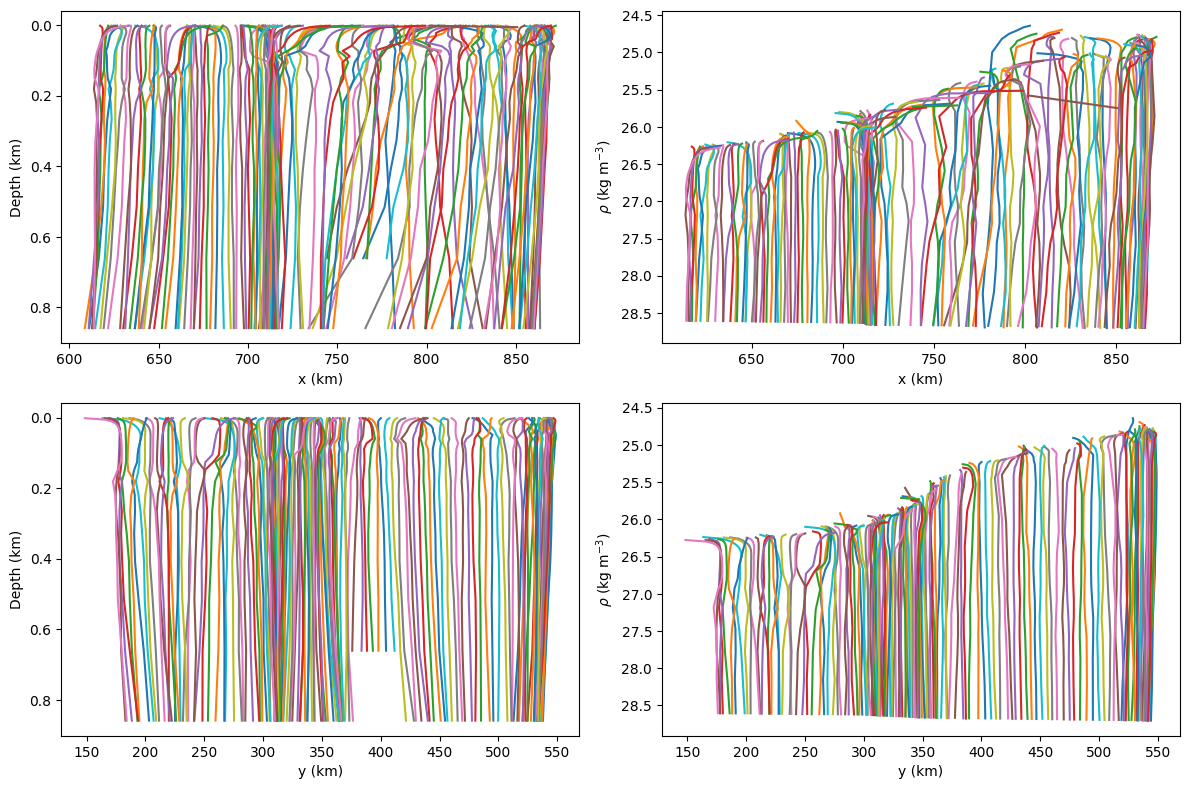

In [12]:
eddy = 1783
fig, axs = plt.subplots(2, 2, figsize=(12,8))
for d, day in enumerate(dic_rho_sample[f'Eddy{eddy}']):
    df = dic_rho_sample[f'Eddy{eddy}'][day]
    depth_mask = -df.Depth/1000 <= 1
    rho_mask = df.rho <= 29
    axs[0,0].plot(df[depth_mask].x, -df[depth_mask].Depth/1000)
    axs[0,0].set_xlabel('x (km)'); axs[0,0].set_ylabel('Depth (km)')
    axs[0,1].plot(df[rho_mask].x, df[rho_mask].rho)
    axs[0,1].set_xlabel('x (km)'); axs[0,1].set_ylabel(r'$\rho$ (kg m$^{-3}$)')
    axs[1,0].plot(df[depth_mask].y, -df[depth_mask].Depth/1000)
    axs[1,0].set_xlabel('y (km)'); axs[1,0].set_ylabel('Depth (km)')
    axs[1,1].plot(df[rho_mask].y, df[rho_mask].rho)
    axs[1,1].set_xlabel('y (km)'); axs[1,1].set_ylabel(r'$\rho$ (kg m$^{-3}$)')
axs[0,0].invert_yaxis(); axs[0,1].invert_yaxis()
axs[1,0].invert_yaxis(); axs[1,1].invert_yaxis()
plt.tight_layout()
        

In [ ]:
df_rho_tilt = compute_tilt_data(dic_rho_sample[f'Eddy{eddy}'], eddy, num=6, depth_int=0.05, max_depth=29, )
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(df_rho_tilt.TiltDis)
axs[0].set_title('TD - rho')
df = df_eddies[df_eddies.Eddy==eddy]
axs[1].plot(df.Day, df.TiltDis)
axs[1].set_title('TD - Depth')
plt.tight_layout()


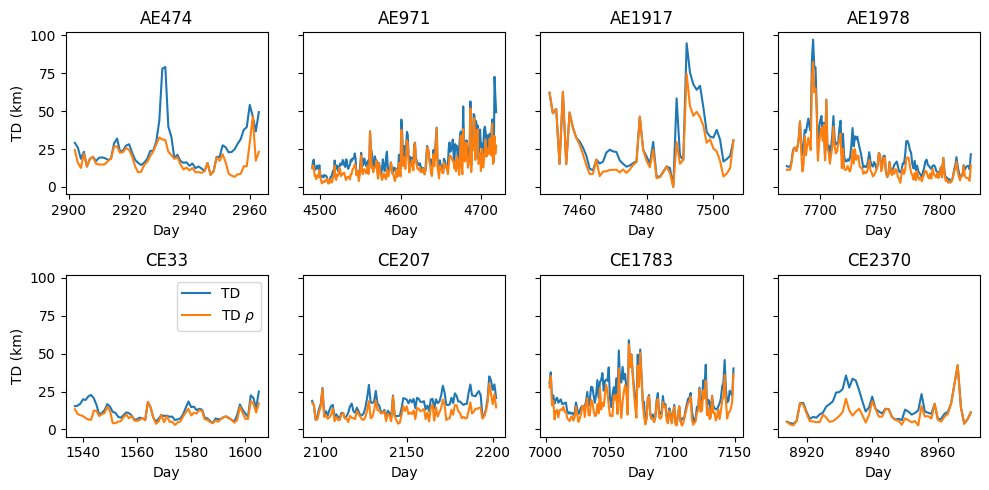

In [40]:
df_rho_tilt = pd.DataFrame(columns = ['Eddy', 'Day', 'TD', 'TD_rho'])
for eddy in dic_rho_sample.keys():
    dic = dic_rho_sample[eddy]
    for day in dic.keys():
        df = dic[day]
        if len(df):
            TD_rho, _, _ = tilt_distance_LI(df.x, df.y, df.rho, zmax=29)
            TD, _, _ = tilt_distance_LI(df.x, df.y, -df.Depth/1000, zmax=1)
            df_rho_tilt.loc[len(df_rho_tilt)] = {'Eddy': int(eddy[4:]), 'Day': int(day[3:]), 'TD': TD, 'TD_rho': TD_rho}
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)
for e, eddy in enumerate(df_rho_tilt.Eddy.unique()):
    ax = axs[e // 4, e % 4]
    df = df_rho_tilt[df_rho_tilt.Eddy==eddy]
    ax.plot(df.Day, df.TD, label='TD' if e==4 else '')
    ax.plot(df.Day, df.TD_rho, label=r'TD $\rho$' if e==4 else '')
    if e==4:
        ax.legend()
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('TD (km)'); axs[1,0].set_ylabel('TD (km)')
plt.tight_layout()
